In [1]:
# 1. Transform into 3 images
# 1.1. (C x T) => (3 x 150)
# 1.2. xy, xz, yz and show the temporal evolution => apply CNN (sparse representation)

# 2. Similar idea but with fully connected networks
# 2.1. flatten all => try to predict
# 2.2. 3 x 150 => serve each coordinate to a single perceptron
# 2.3. flatten all => go through latent space (create embeddings) => predict over latent space
# 2.4. 150 x 3 => serve each datapoint to a single perceptron => 150 perceptrons on the first layer

# Normalizare:
# normalizare x, y, z peste dimensiunea temporala => (3,) medii, peste tot datasetu
# normalizare x, y, z separat pentru fiecare moment in parte => (3 x 150) medii, peste tot datasetu

# (f, 1, 1) => for each temporal point
# (t, 1, 1) => all temporal values for one feature
# (1, f, x)

In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os as so
import numpy as ny
from os import path
import pandas as ps
import pathlib as pb
from typing import List
import matplotlib.pyplot as pt
from modules import processing as pg
from numpy.random import default_rng


# Use GPU if available
so.environ['CUDA_VISIBLE_DEVICES'] = '0'

2022-11-26 11:54:59.436577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 11:54:59.554606: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-26 11:55:00.047800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/lib64:
2022-11-26 11:55:00.047838: W tensorflow/compiler/x

In [4]:
import tensorflow as tw
from tensorflow import Tensor

# Show warning if running on CPU
available_devices = list(map(lambda d: d.device_type, tw.config.list_physical_devices()))

if 'GPU' not in available_devices:
  print('Available devices = ', tw.config.list_physical_devices())
  print('Warning: running on CPU only')

# Configure the paths to the data files
ROOT_PATH = pb.Path('..')
DATASET_PATH = pb.Path(path.join(ROOT_PATH, 'data'))
DATASET_TEST_PATH = pb.Path(path.join(DATASET_PATH, 'test'))
DATASET_TRAIN_PATH = pb.Path(path.join(DATASET_PATH, 'train'))
DATASET_TRAIN_LABELS_FILEPATH = pb.Path(path.join(DATASET_PATH, 'train_labels.csv'))

2022-11-26 11:55:00.584615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 11:55:00.598483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 11:55:00.598638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# Read train labels raw and use them for lookup
train_labels_lookup = ps.read_csv(DATASET_TRAIN_LABELS_FILEPATH)

# Fetch eatch train sample and do lookup for the corresponding label
train_data = []
train_labels = []
for sample_path in sorted(DATASET_TRAIN_PATH.glob('*.csv')):
  # Lookup the label
  train_label = train_labels_lookup[train_labels_lookup['id'] == int(sample_path.stem)]
  train_labels.append(train_label['class'].item())

  # Read the sample and convert it to a tf compatible format
  train_entry = ps.read_csv(sample_path, header=None, names=['x', 'y', 'z'])
  train_data.append(tw.convert_to_tensor(train_entry))

print('Number of training samples: ', len(train_data))
print('Shape of a training sample: ', train_data[0].shape)

# Read test samples
test_data = []
for sample_path in sorted(DATASET_TEST_PATH.glob('*.csv')):
  test_entry = ps.read_csv(sample_path, header=None, names=['x', 'y', 'z'])
  test_data.append(tw.convert_to_tensor(test_entry))

print('Number of testing samples: ', len(test_data))
print('Shape of a testing sample: ', test_data[0].shape)

2022-11-26 11:55:00.662796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 11:55:00.663844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 11:55:00.663977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 11:55:00.664051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1

Number of training samples:  9000
Shape of a training sample:  (150, 3)
Number of testing samples:  5000
Shape of a testing sample:  (150, 3)


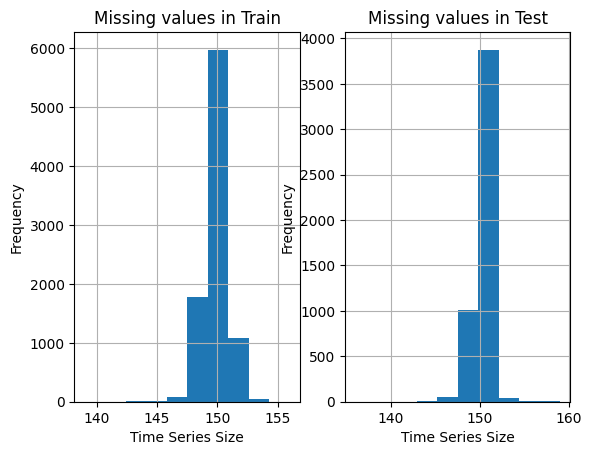

In [6]:
# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in train_data]
test_sizes = [sample.shape[0] for sample in test_data]

# Display missing value stats
pt.figure()
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Missing values in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

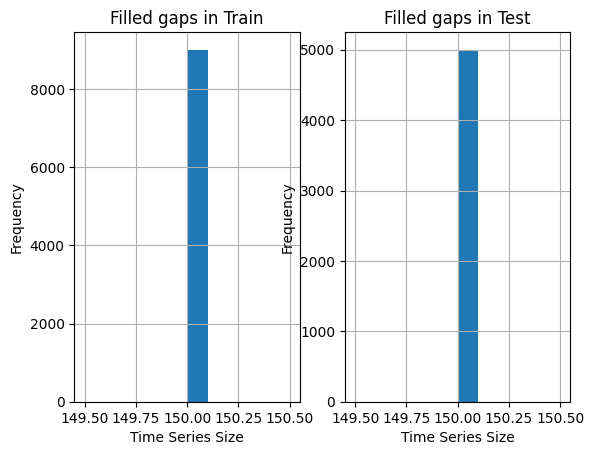

In [7]:
# Fill missing gaps and drop additional points
train_data_proc = pg.fill_missing_values(train_data, 150)
test_data_proc = pg.fill_missing_values(test_data, 150)

# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in train_data_proc]
test_sizes = [sample.shape[0] for sample in test_data_proc]

# Display missing value stats
pt.figure()
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Filled gaps in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

In [8]:
# Compute the mean and std over the training data across the temporal dimension
train_mean = ny.mean(train_data_proc, axis=(0, 1))
train_std = ny.std(train_data_proc, axis=(0, 1))
print('train_mean = ', train_mean)
print('train_std = ', train_std)

# Scale the features for both training and testing
train_data_norm = (train_data_proc - train_mean) / train_std
test_data_norm = (test_data_proc - train_mean) / train_std

# Reshape the input for the network
train_data_in = tw.expand_dims(train_data_norm, axis=1)
test_data_in = tw.expand_dims(test_data_norm, axis=1)

# Map test labels to [0, 19] and encode them using one-hot
train_labels_out = ny.array(train_labels) - 1
train_labels_one_hot = tw.raw_ops.OneHot(indices=train_labels_out, depth=20, on_value=1.0, off_value=0.0)

train_mean =  [-0.21519942  4.7317077   8.01793261]
train_std =  [0.83531283 1.20546571 1.06085159]


In [34]:
from nvitop.callbacks.keras import GpuStatsLogger
from tensorflow.keras.optimizers import Adam
from typing import TypedDict, Callable

class TrainParams(TypedDict):
  n_folds: int
  n_batch: int
  n_epochs: int

class TCNNParams(TypedDict):
  optim: Callable[[], tw.keras.optimizers.Optimizer]
  m_init: tw.keras.initializers.VarianceScaling
  activ_fn: tw.keras.layers.Activation
  n_filters: int
  dropout: float
  n_units: int

def create_tcnn_model(hparams: TCNNParams) -> tw.keras.Model:
  model_tcnn = tw.keras.Sequential([
    tw.keras.layers.InputLayer(input_shape=(1, 150, 3)),

    tw.keras.layers.Conv2D(hparams['n_filters'], kernel_size=(1, hparams['s_filters']), padding='same', kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.Conv2D(hparams['n_filters'], kernel_size=(1, hparams['s_filters']), padding='same', kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 2), padding='same'),
    tw.keras.layers.Dropout(hparams['dropout']),

    tw.keras.layers.Conv2D(hparams['n_filters'] * 2, kernel_size=(1, hparams['s_filters']), padding='same', kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.Conv2D(hparams['n_filters'] * 2, kernel_size=(1, hparams['s_filters']), padding='same', kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 2), padding='same'),
    tw.keras.layers.Dropout(hparams['dropout']),

    tw.keras.layers.Conv2D(hparams['n_filters'] * 4, kernel_size=(1, hparams['s_filters']), padding='same', kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.Conv2D(hparams['n_filters'] * 4, kernel_size=(1, hparams['s_filters']), padding='same', kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 2), padding='same'),
    tw.keras.layers.Dropout(hparams['dropout']),

    tw.keras.layers.Flatten(),

    tw.keras.layers.Dense(hparams['n_units'], kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.Dropout(hparams['dropout']),

    tw.keras.layers.Dense(hparams['n_units'] * 2, kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.Dropout(hparams['dropout']),

    tw.keras.layers.Dense(hparams['n_units'] * 2, kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.Dropout(hparams['dropout']),

    tw.keras.layers.Dense(hparams['n_units'] * 2, kernel_initializer=hparams['m_init']),
    tw.keras.layers.BatchNormalization(),
    hparams['activ_fn'],
    tw.keras.layers.Dense(20, 'softmax')
  ], name='TCNN')

  model_tcnn.compile(optimizer=hparams['optim'](),
                    metrics=['categorical_accuracy'],
                    loss='categorical_crossentropy')

  return model_tcnn

def epoch_graph_callback() -> tw.keras.callbacks.Callback:
  return tw.keras.callbacks.TensorBoard(log_dir=ROOT_PATH / 'logs',
                                        write_graph=True)

def gpu_utiliz_callback() -> tw.keras.callbacks.Callback:
  return GpuStatsLogger(['/gpu:0'], memory_utilization=True, gpu_utilization=True)

def periodic_rate_decrementer(start: int, period: int, factor: float) -> Callable[[int, float], float]:
  def stabilize_lr(epoch: int, learn: float) -> float:
    if epoch < start:
      return learn
    if (epoch - start) % period == 0:
      return learn * factor
    return learn
  return stabilize_lr

def lr_updater_callback() -> tw.keras.callbacks.Callback:
  return tw.keras.callbacks.LearningRateScheduler(
    verbose=1,
    schedule=periodic_rate_decrementer(30, 10, 0.6)
  )

def fitting_callbacks() -> List[tw.keras.callbacks.Callback]:
  return [
    epoch_graph_callback(),
    gpu_utiliz_callback(),
    lr_updater_callback()
  ]


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 1/150


2022-11-26 12:47:10.165976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_132/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 [==============================] - 4s 9ms/step - loss: 1.7765 - categorical_accuracy: 0.4238 - gpu_id: 0/utilization.memory (%): 1.0000 - gpu_id: 0/utilization.gpu (%): 25.0000 - gpu_id: 0/memory.used (MiB): 23573.3125 - gpu_id: 0/memory.free (MiB): 648.5000 - val_loss: 3.6879 - val_categorical_accuracy: 0.1767 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 2/150
113/113 [==============================] - 1s 7ms/step - loss: 0.7669 - categorical_accuracy: 0.7304 - gpu_id: 0/utilization.memory (%): 4.0000 - gpu_id: 0/utilization.gpu (%): 24.0000 - gpu_id: 0/memory.used (MiB): 23678.3125 - gpu_id: 0/memory.free (MiB): 543.5000 - val_loss: 4.3828 - val_categorical_accuracy: 0.2344 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 3/150
113/113 [==============================] - 1s 8ms/step - loss: 0.5455 - categorical_accuracy: 0.8044 - gpu_id: 0/utilization.memory (%): 1

KeyboardInterrupt: 

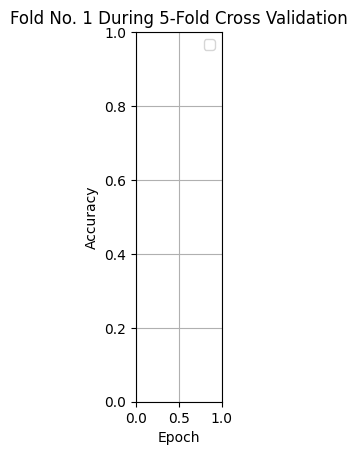

In [36]:
from sklearn.model_selection import KFold

# Display periodic plots across each fold
pt.figure()

# Reformat to sklearn compatible format
train_samples_ny = train_data_in.numpy().reshape(train_data_in.numpy().shape[0], -1)
train_labels_ny = ny.expand_dims(ny.array(train_labels), axis=1)

# Configure t_loop and model hparams
tparams: TrainParams = {
  'n_folds': 5,
  'n_batch': 64,
  'n_epochs': 150,
}
hparams: TCNNParams = {
  'optim': lambda: Adam(learning_rate=2e-4, weight_decay=9e-6),
  'm_init': tw.keras.initializers.GlorotNormal(seed=93),
  'activ_fn': tw.keras.layers.Activation('relu'),
  's_filters': 7,
  'n_filters': 64,
  'n_units': 724,
  'dropout': 0.3,
}

# Train and validate using crossvalidation technique
val_accy, val_loss = [], []
trn_accy, trn_loss = [], []
for i, (fold_train, fold_valid) in enumerate(KFold(shuffle=True, n_splits=tparams['n_folds']).split(train_samples_ny, train_labels_ny)):
  # Show progress for each fold
  pt.subplot(1, tparams['n_folds'], i + 1)
  pt.title(f'Fold No. {i + 1} During {tparams["n_folds"]}-Fold Cross Validation')
  pt.legend(['train_accy', 'valid_accy'])
  pt.ylabel('Accuracy')
  pt.xlabel('Epoch')
  pt.grid(True)

  # Transform points into compatible integer indices
  fold_train, fold_valid = tw.convert_to_tensor(fold_train, dtype=tw.int32), \
                           tw.convert_to_tensor(fold_valid, dtype=tw.int32)

  # Create new model with random weights
  model_tcnn = create_tcnn_model(hparams)

  # Gather points for each step
  train_samples_fold = tw.gather(train_data_in, fold_train)
  valid_samples_fold = tw.gather(train_data_in, fold_valid)
  train_labels_fold = tw.gather(train_labels_one_hot, fold_train)
  valid_labels_fold = tw.gather(train_labels_one_hot, fold_valid)

  # Learn on training data and predict on valid set
  fold_history = model_tcnn.fit(train_samples_fold, train_labels_fold,
                 validation_data=(valid_samples_fold, valid_labels_fold),
                 batch_size=tparams['n_batch'], epochs=tparams['n_epochs'],
                 workers=8, use_multiprocessing=True, initial_epoch=0,
                 callbacks=fitting_callbacks())

  # Save max valid & train accy for the current fold
  val_accy.append(fold_history.history['val_categorical_accuracy'][-1])
  val_loss.append(fold_history.history['val_loss'][-1])
  trn_accy.append(fold_history.history['categorical_accuracy'][-1])
  trn_loss.append(fold_history.history['loss'][-1])

  # Display fold results
  pt.plot(ny.arange(tparams['n_epochs']), fold_history.history['categorical_accuracy'])
  pt.plot(ny.arange(tparams['n_epochs']), fold_history.history['val_categorical_accuracy'])

# Show results across all folds
pt.show()
pt.figure()
print(f'mean_val_loss = {ny.mean(val_loss)}')
print(f'mean_val_accy = {ny.mean(val_accy)}')
print(f'mean_trn_loss = {ny.mean(trn_loss)}')
print(f'mean_trn_accy = {ny.mean(trn_accy)}')

# Show val across folds
pt.subplot(1, 2, 1)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Validation Accuracy')
pt.plot(ny.arange(tparams['n_folds']), val_accy)

# Show train across folds
pt.subplot(1, 2, 2)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Training Accuracy')
pt.plot(ny.arange(tparams['n_folds']), trn_accy)
pt.show()


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 1/150


2022-11-26 12:48:06.969738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_138/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 4s 7ms/step - loss: 1.7646 - categorical_accuracy: 0.4306 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 2/150
110/110 [==============================] - 1s 6ms/step - loss: 0.7658 - categorical_accuracy: 0.7189 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 3/150
110/110 [==============================] - 1s 7ms/step - loss: 0.5398 - categorical_accuracy: 0.8040 - lr: 2.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 4/150
110/110 [==============================] - 1s 7ms/step - loss: 0.4411 - categorical_accuracy: 0.8444 - lr: 2.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 5/150
110/110 [==============================] - 1s 7ms/step - loss: 0.3805 - categorical_accuracy: 0.8686 - lr: 2.0000e-04

Epoch 6: LearningRateScheduler settin

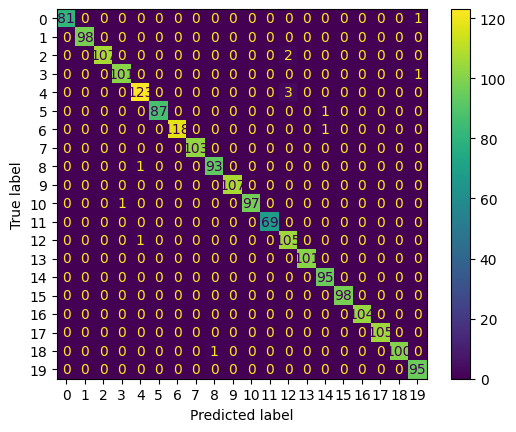

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Recreate model to train from scratch for subtask
model_tcnn = create_tcnn_model(hparams)

# Split data indices
n_subset_valid = 2_000
n_subset_train_i = train_data_in.shape[0] - n_subset_valid
n_subset_valid_i = n_subset_train_i

# Fit model on all training data except last 2_000 entries
model_tcnn.fit(train_data_in[:n_subset_train_i], train_labels_one_hot[:n_subset_train_i],
               batch_size=tparams['n_batch'], epochs=tparams['n_epochs'],
               initial_epoch=0, workers=8, use_multiprocessing=True,
               callbacks=[lr_updater_callback()])

# Predict on last 2_000 entries
y_pred = model_tcnn.predict(train_data_in[n_subset_valid_i:])

# Transform back to labels instead of probs
y_pred_labels = ny.argmax(y_pred, axis=1)
y_grnd_labels = ny.argmax(train_labels_one_hot[n_subset_valid_i:], axis=1)
m_cnf = confusion_matrix(y_grnd_labels, y_pred_labels)
ConfusionMatrixDisplay(m_cnf).plot()
pt.show()

In [38]:
# Instantiate model for final prediction on test set
model_tcnn = create_tcnn_model(hparams)

# Fit on the entire training to have more data for further predictions
model_tcnn.fit(train_data_in, train_labels_one_hot,
               batch_size=tparams['n_batch'], epochs=tparams['n_epochs'],
               initial_epoch=0, workers=8, use_multiprocessing=True,
               callbacks=[lr_updater_callback()])

# Predict unknown labels
test_pred_probs = model_tcnn.predict(test_data_in, batch_size=tparams['n_batch'],
                                      workers=8, use_multiprocessing=True)
test_pred_labels = ny.argmax(test_pred_probs, axis=1) + 1 # [0, 19] -> [1, 20]


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 1/150


2022-11-26 12:50:09.939691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_144/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 4s 7ms/step - loss: 1.6023 - categorical_accuracy: 0.4668 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 2/150
141/141 [==============================] - 1s 7ms/step - loss: 0.6966 - categorical_accuracy: 0.7474 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 3/150
141/141 [==============================] - 1s 7ms/step - loss: 0.4997 - categorical_accuracy: 0.8233 - lr: 2.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 4/150
141/141 [==============================] - 1s 7ms/step - loss: 0.3927 - categorical_accuracy: 0.8626 - lr: 2.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 5/150
141/141 [==============================] - 1s 7ms/step - loss: 0.3129 - categorical_accuracy: 0.8904 - lr: 2.0000e-04

Epoch 6: LearningRateScheduler settin

In [29]:
# Create resulting test object
test_ids = ps.Series([p.stem for p in sorted(DATASET_TEST_PATH.glob('*.csv'))], name='id')
test_classes = ps.Series(test_pred_labels, name='class')
test_results = ps.DataFrame({
  'id': test_ids,
  'class': test_classes,
})

# And store the results obtained by the model using that previously created test frame
test_results.to_csv(DATASET_PATH / 'test_labels_11.csv', mode='w', header=True, index=False)